# Analisis de los Accidentes con Implicaciones de Bicicletas


![](https://static.thenounproject.com/png/11183-200.png)

Primero importamos los paquetes de Python que vamos a requerir para la lectura, limpieza, analisis exploratorio y visualización. Para esto utilizamos:

* **Pandas** - manipulación y analisis de datos para tablas y series de tiempo
* **Datetime** - Conversión a formatos de fecha
* **Re** - biblioteca para expresiones regulares
* **Numpy** - soporte para vectores y matrices
* **Matplotlib** - graficas basado en Matlab
* **Seaborn** - herramientas de visualización mas avanzadas

In [ ]:
import pandas as pd
from datetime import date, datetime
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Utilizaremos el archivo de los [accidentes con implicaciones de bicicletas en Madrid de 2018](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=20f4a87ebb65b510VgnVCM1000001d4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default), para lo cual debemos tener en cuenta las siguientes consideraciones:

* Es un archivo **CSV**
* El archivo no abre con el encoding UTF8, por lo cual hay que utilizar ISO-8859-1. 
* Los datos estan separados por `;` y no `,` 

In [ ]:
acc = pd.read_csv("../dat/AccidentesBicicletas_2018.csv", index_col=False, encoding = "ISO-8859-1", sep=';')

### Revisión de la Estructura de la Tabla

Luego de haber cargado el archivo a nuestro ambiente, exploramos la composición de los datos. Revisamos el numero de filas y columnas, la cantidad de valores vacios, las primeras y ultimas observaciones, el tipo de los datos y el nombre de las **columnas**.

In [ ]:
acc.columns

Revisamos la **forma** de la tabla, que nos devuelve la cantidad de filas y columnas.

In [ ]:
acc.shape

Revisamos la **información** de la tabla, que nos devuelve el numero de datos en cada columna, el tipo de dato y la memoria que ocupa.

In [ ]:
acc.info()

Vemos una **muestra** de la tabla, para revisar la composición de los datos. Tanto de las primeras como de las ultimas observaciones.

In [ ]:
acc.head()

In [ ]:
acc.tail()



Observamos la **descripción** de los datos numericos, donde podemos ver la media, desviación estandar, valor minimo, valor maximo, entre otros.


In [ ]:
acc.describe()

### Limpieza de Datos

Teniendo ya información mas detallada del archivo podemos proceder con su limpieza, eliminando las columnas que no son utiles para el analisis objetivo y convirtiendo los datos a el formato deseado. Por ejemplo, podemos observar que la mayoria de columnas estan en formato de texto. Columnas como la fecha debemos pasar a un formato Datetime y columnas como la edad deben estar en formato numerico. 

En primer lugar, eliminamos las columnas de numero de parte, que no nos agrega información relevante para nuestro analisis y las de condiciones climaticas y del estado del suelo, excepto la de lluvia y mojado, pues muy pocos accidentes ocurren bajo esas condiciones por lo cual no agregaran valor. Además, elimnamos el tipo de vehiculo, pues todas las observaciónes son igual a bicicleta y tipo de persona porque la mayoria de los resultados son **CONDUCTOR**, unos pocos son **VIAJEROS** y solo una observación es **TESTIGO**. 

In [ ]:
acc = acc.drop(['Nº PARTE', 'CPFA Granizo', 'CPFA Hielo',
       'CPFA Niebla', 'CPFA Seco', 'CPFA Nieve', 'CPSV Aceite',
       'CPSV Barro', 'CPSV Grava Suelta', 'CPSV Hielo', 'CPSV Seca Y Limpia', 'Tipo Vehiculo', 'TIPO PERSONA'], 1)

Ahora, renombramos las columnas para tener nombres simples, faciles de manipular.

In [ ]:
etiquetas = ['fecha', 'rango_hora', 'dia_semana', 'distrito', 'lugar', 'numero', 'lluvia', 'mojado', 'victimas', 
             'tipo_accidente', 'sexo', 'lesividad', 'rango_edad']
acc.columns = etiquetas

Extraemos de la columna `rango hora`, la hora de inicio del rango y creamos una nueva columna con esos datos

In [ ]:
def extrae_hora(t):
    _, horain, _, _, = t.rango_hora.split(' ')
    return horain

acc['horain'] = acc.apply(extrae_hora, axis = 1)

Juntamos la hora con la fecha y utilizamos una formula para convertir los datos de la columna `fecha`, de texto a **datetime**.

In [ ]:
acc['fecha'] = acc.fecha + ' ' + acc.horain

In [ ]:
formato2 = '%d/%m/%Y %H:%M'
fecha = '01/01/1949 20:30'

def parse_fecha(fecha):
        a = datetime.strptime(fecha, formato2)
        return a

acc.fecha = acc.fecha.apply(parse_fecha)

Tambien utilizamos una función para extraer de la columna `rango edad`, la edad promedio entre el maximo y minimo. Teniendo en cuenta a la vez que hay filas donde el valor es desconocido y sera remplazado por `missing value`.

In [ ]:
def extrae_edad(e):
    try:
        _, edadmin, _, _, _, = e.rango_edad.split(' ')
        _, _, _, edadmax, _, = e.rango_edad.split(' ')
        return (int(edadmin) + int(edadmax))/2
    except:
        return None

acc['edad'] = acc.apply(extrae_edad, axis = 1)

Adicionalmente, convertimos la columna de edad, extraida previamente, de texto a `float`. Utilizamos el parametro errors con el valor de `coerce` para que convierta los valores no numericos en `missing values`.

In [ ]:
acc['edad'] = pd.to_numeric(acc['edad'], errors='coerce')

Construimos una columna con el valor del mes de cuando ocurrio el accidente.

In [ ]:
acc['mes'] = acc.apply(lambda fila: fila.fecha.month, axis=1)

Examinando detalladamente el campo de lugar, que tiene información sobre la ubicacion donde se produjo el accidente, vemos que las observaciones tienen información de sobra. En algunos campos hay dos direcciones y al final de la observación esta el texto `NUM`. Esto puede dificultar convertir la dirección a coordenadas de latitud, longitud por lo cual eliminaremos una dirección y el texto que sobra. 

In [ ]:
def extrae_calle(e):
    try:
        direccion, _  = e.lugar.split('-')
        return direccion
    except:
        return e.lugar.replace('NUM', '')

acc['direccion'] = acc.apply(extrae_calle, axis = 1)

Eliminamos los espacios vacios de nuestros resultados para no tener conflictos al realizar filtros.

In [ ]:
acc = acc.apply(lambda fila: fila.str.strip() if fila.dtype == 'object' else fila)

Ahora que tenemos un valor limpio de la dirección, vamos a convertir el tipo de dato del numero de la calle de texto a numerico, para luego unir al campo de dirección el numero de la calle pero unicamente en los casos que el numero sea superior a cero.

In [ ]:
acc['numero'] = pd.to_numeric(acc['numero'], errors='coerce')

In [ ]:
def suma_num(e):
    if e.numero > 0:
        return e.direccion + ' ' + str(int(e.numero))
    else:
        return e.direccion
    
acc['direccion'] = acc.apply(suma_num, axis = 1)

Una vez que tenemos la dirección del accidente de forma precisa, podemos utilizar funciones para convertir la dirección en coordenadas de latitud y longitud. Investigando encontramos [geopy 1.18.1](https://pypi.org/project/geopy/). Geopy es un cliente de web services de geocoding, que hace posible identificar las coordenadas de direcciones, ciudades y paises. 

Para poder utilizarlo hay que descargar el paquete en el prompt de Anaconda, o similares, utilizando el comando `pip install geopy` y despues importar el paquete.

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")

Ahora definimos las funciones que van a extraer la longitud y latitud.

In [ ]:
def latitud(e):
    try:
        location = geolocator.geocode(e + ' MADRID')
        return location.latitude
    except:
        return None

def longitud(e):
    try:
        location = geolocator.geocode(e + ' MADRID')
        return location.longitude
    except:
        return None

Finalmente, utilizamos un bucle para extraer cada latitud y longitud para almacenarlos en la tabla. **Es importante tener en cuenta** que dado que son cientos de solicitudes al cliente, se deben realizar de manera espaciada para evitar ser bloqueados.

In [ ]:
acc['latitud'] = [latitud(i) for i in acc.direccion]

In [ ]:
acc['longitud'] = [longitud(i) for i in acc.direccion]

Para tener un desempeño optimo de la memoria ocupada por cada dataset convertimos algunas variables de formato texto a formato `categorico`. 

In [ ]:
acc.lluvia = acc.lluvia.astype('category')
acc.mojado = acc.mojado.astype('category')

Al haber hecho la conversión de las columnas `rango hora` y `rango edad`, a formatos mas utiles, los podemos eliminar de la tabla. Adicionalmente, al haber unificado la información de lugar, incluyendo el numero y dirección, tambien podemos eliminar las columnas de `lugar` y `numero`.

In [ ]:
acc = acc.drop(['rango_hora', 'rango_edad', 'lugar', 'numero'], 1)

### Analisis Exploratorio Estadistico y Visual

Una vez que contamos con los datos que deseamos evaluar y los tenemos disponibles en el formato deseado podemos empezar a explorar los resultados para tener una idea de la distribución de las variables y como estan relacionadas. 

Para realizar esta tarea podemos utilizar herramientas estadisticas como la desviación estandar, media, mediana, maximos y minimos. Tambien podemos utiliar histogramas y graficos de dispersión.

_Empezamos_, analizando con mayor profundidad las columnas de interes. Detallamos los resultados y su **distribucción**, de las siguientes columnas:

* Numero de victimas

In [ ]:
acc['victimas'].value_counts(dropna=False)

En la columna de victimas vemos que hay un outlier que puede contaminar la muestra y dificultar el analisis grafico de las variables. Por lo cual, haremos una copia de la tabla que no incluya este valor.

In [ ]:
acc = acc[acc['victimas'] < 14]

* Tipo de Accidente

In [ ]:
acc['tipo_accidente'].value_counts(dropna=False)

* Lesividad

In [ ]:
acc['lesividad'].value_counts(dropna=False)

* Lluvia

In [ ]:
acc['lluvia'].value_counts(dropna=False)

* Distrito

In [ ]:
acc['distrito'].value_counts(dropna=False)

* Dia de la Semana

In [ ]:
acc['dia_semana'].value_counts(dropna=False)

* Hora Inicial

In [ ]:
acc['horain'].value_counts(dropna=False)

* Sexo

In [ ]:
acc['sexo'].value_counts(dropna=False)

* Edad

In [ ]:
acc['edad'].value_counts(dropna=False)

In [ ]:
acc['mes'].value_counts(dropna=False)

De este analisis podemos concluir que a grandes rasgos no hay problemas masivos con la calidad de los datos. En la columna de edad tenemos 21 `missing values`, en la columna de sexo hay 11 resultados no asignados, en la columna de lesividad hay 9 resultados no asignados, las columnas de latitud y longitud si cuentan con al rededor de 80 `missing values` pero las demas columnas tienen valores completos en la totalidad de sus observaciones.

Volvemos a realizar las funciones de info y describe para ver como los cambios han afectado las columnas, los tipo de datos, el peso del archivo y, de las variables numericas, observar la media, error estandar, maximo, minimo y percentiles. Podemos ver que el archvo paso de 142.3+ KB a 78.0+ KB. Previamente habian int64(1), object(25) y pasamos a category(2), datetime64ns(1), float64(3), int64(2), object(7).

In [ ]:
acc.info()

De las variables numericas podemos concluir que la mayoria de los accidentes tienen solo una victima y que la edad promedio es de 36 años.

In [ ]:
acc.describe()

**Despues**, hacemos una serie de agrupaciones para ver como se comportan los datos entre las variables.

En primer lugar, evaluamos el distrito con el dia de semana, agrupado por la sumatoria de las victimas. Con esto podemos ver que dias de la semana hay mas accidentes por distrito.

In [ ]:
tmp = acc.groupby(['distrito', 'dia_semana']).agg({'victimas': 'sum'})
tmp

Ahora, agrupamos por dia de semana y tipo de lesividad agregando por la suma de las victimas, para evaluar si varian la gravedad de las lesiones por dia de la semana. A gran escala vemos que las variables mantienen un comportamiento proporcional entre los diferentes dias de la semana. 

In [ ]:
tmp = acc.groupby(['dia_semana', 'lesividad']).agg({'victimas': 'sum'})
tmp

Realizamos una agrupación por distrito, evaluando la mediana de la edad. Vemos que la mayoria de los distritos tienen una mediana de 30 o mas años. Habiendo unicamente una excepción de 22 años y 5 con al menos 40 años.

In [ ]:
tmp = acc.groupby(['distrito']).agg({'edad': 'median'})
tmp

Hacemos una agrupación para ver como se distribuyen los tipos de accidente entre los meses del año. De la tabla, podemos ver que la cantidad de accidentes tiene un comportamiento proporcional através del tiempo. Siendo las categorias de **CAÍDA BICICLETA** y **COLISIÓN DOBLE** las mas recurrentes todos los meses.

In [ ]:
tmp = acc.groupby(['mes', 'tipo_accidente']).agg({'tipo_accidente': 'count'})
tmp

Adicional a las agrupaciones podemos realizar filtros deseados para encontrar resultados especificos dentro de la tabla.

Hacemos una busqueda de los accidentes ocurridos en lunes del tipo atropello. Vemos que hay 11 observaciones, que ninguno ocurrio con lluvia o estado mojado y todos de hombres. 

In [ ]:
acc[(acc['dia_semana'] == 'LUNES') & (acc['tipo_accidente'] == 'ATROPELLO')]

Ademas de los filtros, podemos organizar los resultados por campo. En este caso, buscamos los accidentes de lesividad de herida grave, de hombres en el mes de septiembre. Todo ordenado por orden alfabetico del distrito.

In [ ]:
acc[(acc['lesividad'] == 'HG') & (acc['sexo'] == 'HOMBRE') & (acc['mes'] == 9.0)].sort_values('distrito')

Empezamos realizando el **analisis exploratorio visual**. Iniciamos con la distribución de las variables de mes y edad.

Utilizamos el proximo comando para que se vean más grandes los gráficos en el notebook.

In [2]:
from matplotlib import rcParams
import matplotlib
%matplotlib inline
rcParams['figure.figsize'] = 18, 10
sns.set_context('talk')
sns.set_style("darkgrid")


La edad vemos que tiene una distribucción muy parecida a la normal. Tiene el pico en el medio, aunque un poco inclinado a la izquierda, siendo las personas de 25 a 35 años las que mas accidentes tienen, lo cual es consistente con el hecho que son las personas que mas utilizan la bicicleta, mientras que las personas menores a los 15 años y mayores a los 40 tienden a utilizar en menor proporcion este medio.

In [ ]:
tmp = acc[acc.edad > 0]
g = sns.distplot(tmp.edad, bins=13)

plt.title('Histograma Edad')
plt.xlabel('Edad')
plt.show()


Los meses tienen una distribucción menos regular, vemos que en la temporada de verano es cuando mas accidentes se presentan siendo por el contrario el invierno donde menos accidentes hay con un leve incremento en enero en comparación a diciembre, febrero y marzo.

In [ ]:
g = sns.distplot(acc.mes, bins=12)

plt.title('Histograma Mes')
plt.xlabel('Mes')
plt.show()


En cuanto al comportamiento entre los dias de la semana, vemos que el jueves es cuando mas accidentes se presentan, con cerca de 120, el domingo es cuando menos accidentes hay con cerca de 90. Los demas dias tienen un comportamiento muy parejo oscilando entre 95 y 105.

In [ ]:
o1 = ['LUNES', 'MARTES', 'MIERCOLES', 'JUEVES', 'VIERNES', 'SABADO', 'DOMINGO']

g = sns.countplot(x='dia_semana', order = o1, data=acc, palette="Set1")

plt.title('Accidentes por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel("Cantidad de accidentes")
plt.show()

Para organizar las variables en los graficos definimos el orden.

In [ ]:
o = ['CENTRO', 'RETIRO', 'CHAMBERI', 'MONCLOA-ARAVACA', 'SALAMANCA', 
 'CARABANCHEL', 'LATINA', 'TETUAN', 'ARGANZUELA', 'FUENCARRAL-EL PARDO', 
 'PUENTE DE VALLECAS', 'CHAMARTIN', 'CIUDAD LINEAL', 'SAN BLAS', 'HORTALEZA',
 'USERA', 'VILLA DE VALLECAS', 'MORATALAZ', 'VILLAVERDE', 'VICALVARO', 'BARAJAS']

o2 = ['1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00',
        '11:00', '12:00','13:00','14:00', '15:00', '16:00', '17:00', 
      '18:00', '19:00', '20:00', '21:00', '22:00', '23:00', '00:00']

o4 = ['IL', 'HL', 'HG']

o5 = ['IL', 'HL', 'HG', 'NO ASIGNADA']

Hacemos un grafico de dispersión evaluando el tipo de lesividad y su relación con la edad. Unicamente vemos que las heridas leves son las que mayor observaciones tienen pero no parece haber un aumento en las heridas graves con un aumento en la edad, aunque si se presenta una ausencia de heridas graves en sujetos menores de 20 años.

In [ ]:
g = sns.swarmplot(x='lesividad', y='edad', order = o4, data=acc[acc['lesividad'] != 'NO ASIGNADA'])

plt.title('Dispersión de accidentes por lesividad y edad')
plt.xlabel('Lesividad')
plt.ylabel("Edad")
plt.show()

Hacemos tambien un grafico de dispersión evaluando el sexo y la edad. Vemos que los hombres tienen muchos mas accidentes y en especial con los usuarios menores de 40. 

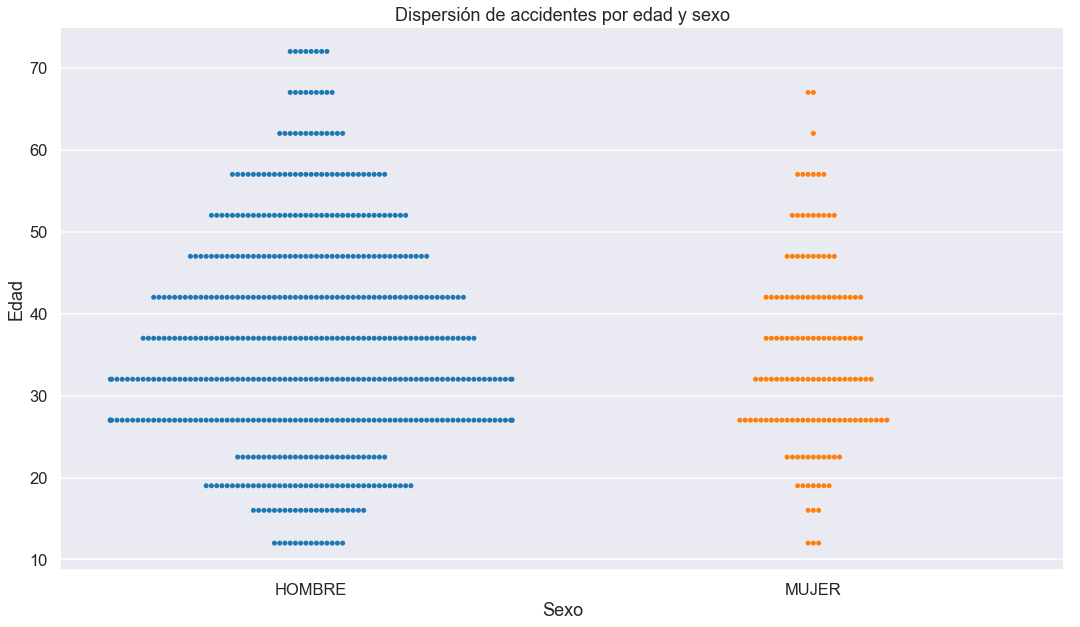

In [8]:
g = sns.swarmplot(x='sexo', y='edad', data=acc[acc.sexo != 'NO ASIGNADO'])

plt.title('Dispersión de accidentes por edad y sexo')
plt.xlabel('Sexo')
plt.ylabel("Edad")
plt.show()

Para saber cual es el distrito con mayores accidentes creamos una grafica de barras horizontal. Observamos que el centro es de lejos el distrito mas accidentado, lo cual es bastante util para determinar donde enfocar las estrategias de prevencción de accidentes. Retiro, Chamberi, Moncloa-Aravaca y Salamanca tambien tienen cifras altas. 

In [ ]:
g = sns.countplot(y='distrito', data=acc, palette='Set1', order=o )

plt.title('Cantidad de accidentes por distrito')
plt.xlabel('Cantidad de accidentes')
plt.ylabel("Distrito")
plt.show()

Ahora bien, la distribucción de los accidentes en las horas del dia tienen una cola grande sobre la izquierda. Es decir, que en las horas de la madrugada es cuando menos accidentes hay, logicamente pues es tambien cuando menos se utilizan las bicicletas. Por otro lado, las 19:00 es cuando mas accidentes ocurren, siendo alto tambien a las 9:00, 13:00 y 18:00, horas donde la mayoria de la gente se desplaza a estudiar, almorzar y trabajar.

In [ ]:
g = sns.countplot(x='horain', data=acc, order=o2, palette='Set1')

plt.title('Cantidad de accidentes por hora')
plt.xlabel('Hora')
plt.ylabel("Cantidad de accidentes")
plt.show()

Utilizando un catplot, podemos construir un grafico comparando los valores por el resultado de una variable. En este caso, vamos a utilizar la variable sexo, para observar como se relaciona la edad con el tipo de lesividad. En la grafica de dispersión que vimos previamente, del tipo de lesividad, no era claro que existiera una relación. Sin embargo, al utilizar un boxplot vemos un claro incremento en la mediana de la edad de los hombres, entre mas grave sea la lesión. En el caso de las mujeres no observamos ese comportamiento.

In [ ]:
g = sns.catplot(x="lesividad", y='edad', order = o4, col="sexo",
                 data=acc[acc.sexo != 'NO ASIGNADO'], palette='BuPu', kind="box", margin_titles=True)


Analizamos, en los 5 distritos con mas accidentes, la distribucción de los accidentes entre los meses del año, diferenciando los accidentes que se dieron con y sin lluvia. Podemos observar una diferencia marcada entre los distritos, cuando no hubo lluvia. Por ejemplo, el distrito del retiro tiene pocos accidentes en los ultimos meses, mientras que Moncloa tiene menor cantidad en los primeros meses. Centro tiene una distribución mas uniforme en todos los meses excepto en marzo que hubo una reducción en los todos los distritos analizados. Chamberi, por otro lado tiene menores accidentes en los meses que presentan los picos como lo son junio y septiembre, pero la mayoria de sus incidentes se producen en julio y octubre. De los casos con lluvia vemos que retiro es mas afectado en la primera mitad del año mientras que Chamberi y Moncloa al final del año. 

In [ ]:
tmp = acc[(acc.distrito == 'CENTRO') | (acc.distrito == 'RETIRO') | (acc.distrito == 'CHAMBERI') 
           | (acc.distrito == 'MONCLOA-ARAVACA') | (acc.distrito == 'SALAMANCA')]

g = sns.catplot(x="mes", y='distrito', col="lluvia",
                 data=tmp, kind="swarm")



Para analizar como evoluciona el numero de victimas en el año, hacemos una grafica linear que mide el numero de victimas por mes. En el primer trimestre del año, la variable presenta una tendencia negativa. Las cifras van cayendo de enero a febrero y de febrero a marzo. Luego, en el segundo trimestre suben pasando de 40 victimas en marzo a alrededor de 95 en junio. En el tercer trimestre, las cifras caen levemente en julio y mas pronunciado en agosto, para luego subir a valores maximos en spetiembre. En el ultimo trimestre se presenta una caida constante y pronunciada llegando en diciembre a los valores minimos. 

In [ ]:
g = sns.lineplot(x="mes", y='victimas', estimator ='sum', data=acc)

plt.title('Numero de victimas por mes')
plt.xlabel('Mes')
plt.ylabel("Cantidad de victimas")
plt.show()

De la siguiente grafica podemos concluir que la gran mayoria de accidentes que se presentan son de lesividad `Herida Leve`. Los accidentes con implicaciones de `Herida Grave` no son frecuentes aunque se dan en mayor proporción en los hombres, al igual que todos los accidentes en general.

In [ ]:
g = sns.countplot(x="lesividad", data=acc[acc.sexo != 'NO ASIGNADO'], hue='sexo', order = o4)

plt.title('Tipo de lesion por sexo')
plt.xlabel('Lesividad')
plt.ylabel("Cantidad")
plt.show()

Analizando la lesividad, con respecto a los dias de la semana vemos que los dias viernes y sabado ocurren una mayor proporción de accidentes de `Herida Grave`, mientras que lunes y martes ocurren una mayor proporción de `Ilesos`.

In [ ]:
g = sns.countplot(x="dia_semana", data=acc , hue='lesividad', order = o1)

plt.title('Tipo de lesividad por dia de la semana')
plt.xlabel('Dia de la semana')
plt.ylabel("Cantidad")
plt.show()

Como mencionamos previamente, la mayoria de los accidentes afectan solo a una victima. El grafico de violin comprueba que hay pocas observaciones con dos victimas y unicamente en martes, viernes y sabado hay observaciones de accidentes de 3 victimas. 

In [ ]:
g = sns.violinplot(x='dia_semana', y='victimas', data=acc, order = o1)

plt.title('Numero de victimas por dia de la semana')
plt.xlabel('Dia de la semana')
plt.ylabel("Numero de victimas")
plt.show()

Pintaremos en un mapa las ubicaciones de los accidentes de los que se pudieron recuperar las direcciones. Esto nos puede ayudar a determinar si hay zonas de mayor peligro que puedan requerir con mayor prioridad la construcción de ciclo carriles u otras estrategias. Utilizaremos en el mapa una indexación con colores que nos muestren el tipo de lesión del accidente.

In [3]:
import folium
from folium import plugins
from folium.plugins import HeatMap

In [ ]:
m = folium.Map(
    location=[40.4253, -3.7042],
    tiles='OpenStreetMap',
    zoom_start=11
)

for x, i in acc.iterrows():
    
    if i.lesividad == 'HG':
        color = 'red'
    elif i.lesividad == 'HL':
        color = 'orange'
    else:
        color = 'green'
    
    try: 
        folium.Marker([i.latitud, i.longitud], 
                      popup='Numero de victimas: ' + str(i.victimas), 
                      icon=folium.Icon(color=color)).add_to(m)
    except:
        None
m

Para poder interpretar la información de forma mas practica utilizamos mapas de calor, que toman como input una lista de listas por lo cual debemos transformar la estructura de la tabla. En la definición de la nueva estructura podemos aplicar filtros al data frame para realizar comparaciones o analisis detallado de las variables determinadas.


In [ ]:
heat_df = acc[acc['mes']==9] 
heat_df = heat_df[['latitud', 'longitud']]
heat_df = heat_df.dropna(axis=0, subset=['latitud','longitud'])
heat_data = [[row['latitud'],row['longitud']] for index, row in heat_df.iterrows()]

map_hooray = folium.Map(location=[40.4253, -3.7042],
                    zoom_start = 11) 

HeatMap(heat_data).add_to(map_hooray)

map_hooray

In [ ]:
heat_df = acc[acc['horain']=='19:00'] 
heat_df = heat_df[['latitud', 'longitud']]
heat_df = heat_df.dropna(axis=0, subset=['latitud','longitud'])
heat_data = [[row['latitud'],row['longitud']] for index, row in heat_df.iterrows()]

map_hooray = folium.Map(location=[40.4253, -3.7042],
                    zoom_start = 11) 

HeatMap(heat_data).add_to(map_hooray)

map_hooray

Construimos un mapa de calor estructurando la información en una serie de tiempo para pintar los accidentes en el mapa de forma secuencial, basado en el mes en el que se dio el accidente. 

In [7]:
map_hooray = folium.Map(location=[40.416, -3.7042],
                    zoom_start = 12) 

heat_df = acc
heat_df = heat_df[['latitud', 'longitud']]

heat_df['peso'] = acc['fecha'].str[5:7]
heat_df['peso'] = heat_df['peso'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['latitud','longitud', 'peso'])


heat_data = [[[row['latitud'],row['longitud']] for index, row in heat_df[heat_df['peso'] == i].iterrows()] for i in range(0,13)]

hm = plugins.HeatMapWithTime(heat_data,auto_play=False,max_opacity=0.8)
hm.add_to(map_hooray)

map_hooray

C:\Users\alejo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\alejo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Series de Tiempo

Con Pandas podemos convertir las tablas en series de tiempo. Esto se puede lograr asignandole al indice una columna de fecha. De esta forma, podemos agregar o desagregar la información segun la periodicidad deseada. 

In [ ]:
accT = acc.set_index(acc.fecha)

Esto nos permite realizar filtros por fechas o rangos de fechas.

In [ ]:
accT.loc['2018-01-01 10:00' : '2018-01-07 23:59'].head()

Adicionalmente podemos crear nuevas tablas agregando por la periodicidad deseada y escogiendo una función de agregación como suma, promedio, mediana, maximo, minimo, etc.

En este caso, generamos una tabla con una periodicidad diaria, agregando contando los resultados.

In [ ]:
acc_dia = accT.resample('D').count()

Para poder construir graficas con la variabe de fecha, sobreescribimos la columna fecha con los valores del indice. 

In [ ]:
acc_dia.fecha = acc_dia.index
acc_dia.head()

Otro escenario construido, fue agregando con una periodicidad mensual con base en la mediana. Esta formula conserva unicamente variables numericas. Nos permite ver la mediana de la edad en cada mes del año.

In [ ]:
acc_mes = accT.resample('M').median()

In [ ]:
acc_mes['fecha1'] = acc_mes.index
acc_mes.head()

Podemos visualizar esta información con una grafica de linea. De la cual, podemos concluir que en abril es excepcionalmente bajo, llegando a los 25 años. Mientras que, la mayoria de los meses oscila entre 30 y 35 años.

In [ ]:
g = sns.lineplot(x='fecha1', y='edad', estimator ='sum',
                 data=acc_mes)

plt.title('Mediana de la edad por fecha')
plt.xlabel('Fecha')
plt.ylabel("Edad")
plt.show()

Por ultimo, hacemos una tabla de periodicidad mensual, sumando los valores.

In [ ]:
acc_mes_sum = accT.resample('M').sum()

Al estar el mes en un formato numerico, se han sumado las observaciones por mes, por lo cual redefinimos los valores de la columna.

In [ ]:
acc_mes_sum['fecha1'] = acc_mes_sum.index
acc_mes_sum['mes'] = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
acc_mes_sum.head()

Para visualizar los resultados, utilizamos una grafica de barras para medir los meses donde hay mas victimas. Siendo la mediana del numero de victimas 1 y el promedio 1.10, vemos que el numero de victimas se comporta de forma similar a la cantidad de accidentes. Podemos concluir que junio y septiembre son los meses donde hay mas victimas. Diciembre y marzo, son los meses donde menos victimas hay. 

In [ ]:
g = sns.barplot(x='mes', y='victimas', palette = 'Set1', saturation=0.75,
                data=acc_mes_sum)

plt.title('Numero de victimas por mes')
plt.xlabel('Mes')
plt.ylabel("Numero de victimas")
plt.show()

### Exportamos los Archivos y Juntamos las Tablas

Al haber finalizado la limpieza y el analisis del archivo podemos exportar la version final a un archivo de CSV. Adicionalmente, podemos aplicar el mismo tratamiento a los archivos de 2016 y 2017 y juntarlos en un solo archivo.

    Guardamos el archivo de 2018.

In [ ]:
acc.to_csv('../dat/accidentes2018')

Aplicamos el tratamiento al archivo del 2017.

In [ ]:
acc2017 = pd.read_csv("../dat/AccidentesBicicletas_2017.csv", index_col=False, encoding = "ISO-8859-1", sep=';')

In [ ]:
acc2017 = acc2017.drop(['Nº PARTE', 'CPFA Granizo', 'CPFA Hielo',
       'CPFA Niebla', 'CPFA Seco', 'CPFA Nieve', 'CPSV Aceite',
       'CPSV Barro', 'CPSV Grava Suelta', 'CPSV Hielo', 'CPSV Seca Y Limpia', 'Tipo Vehiculo', 'TIPO PERSONA'], 1)

acc2017.columns = etiquetas
#Al tener la ultima fila solo valores inexistentes debemos eliminarla para poder aplicar la limpieza de datos
acc2017 = acc2017.iloc[:756, :]
acc2017['horain'] = acc2017.apply(extrae_hora, axis = 1)
acc2017['fecha'] = acc2017.fecha + ' ' + acc2017.horain
acc2017.fecha = acc2017.fecha.apply(parse_fecha)
acc2017['edad'] = acc2017.apply(extrae_edad, axis = 1)
acc2017['edad'] = pd.to_numeric(acc2017['edad'], errors='coerce')
acc2017['mes'] = acc2017.apply(lambda fila: fila.fecha.month, axis=1)
acc2017['direccion'] = acc2017.apply(extrae_calle, axis = 1)
acc2017 = acc2017.apply(lambda fila: fila.str.strip() if fila.dtype == 'object' else fila)
acc2017['numero'] = pd.to_numeric(acc2017['numero'], errors='coerce')
acc2017['direccion'] = acc2017.apply(suma_num, axis = 1)

In [ ]:
acc2017['latitud'] = [latitud(i) for i in acc2017.direccion]

In [ ]:
acc2017['longitud'] = [longitud(i) for i in acc2017.direccion]

In [ ]:
acc2017.lluvia = acc2017.lluvia.astype('category')
acc2017.mojado = acc2017.mojado.astype('category')
acc2017['victimas'] = pd.to_numeric(acc2017['victimas'], errors='coerce', downcast='integer')

In [ ]:
acc2017 = acc2017.drop(['rango_hora', 'rango_edad', 'lugar', 'numero'], 1)

    Guardamos el archivo de 2017.

In [ ]:
acc2017.to_csv('../dat/accidentes2017')

Aplicamos el tratamiento al archivo del 2016.

In [ ]:
acc2016 = pd.read_csv("../dat/AccidentesBicicletas_2016.csv", index_col=False, encoding = "ISO-8859-1", sep=';')

In [ ]:
acc2016 = acc2016.drop(['Nº PARTE', 'CPFA Granizo', 'CPFA Hielo',
       'CPFA Niebla', 'CPFA Seco', 'CPFA Nieve', 'CPSV Aceite',
       'CPSV Barro', 'CPSV Grava Suelta', 'CPSV Hielo', 'CPSV Seca Y Limpia', 'Tipo Vehiculo', 'TIPO PERSONA'], 1)

acc2016.columns = etiquetas
#Al tener la ultima fila solo valores inexistentes debemos eliminarla para poder aplicar la limpieza de datos
acc2016 = acc2016.iloc[:757, :]
acc2016['horain'] = acc2016.apply(extrae_hora, axis = 1)
acc2016['fecha'] = acc2016.fecha + ' ' + acc2016.horain
acc2016.fecha = acc2016.fecha.apply(parse_fecha)
acc2016['edad'] = acc2016.apply(extrae_edad, axis = 1)
acc2016['edad'] = pd.to_numeric(acc2016['edad'], errors='coerce')
acc2016['mes'] = acc2016.apply(lambda fila: fila.fecha.month, axis=1)
acc2016['direccion'] = acc2016.apply(extrae_calle, axis = 1)
acc2016 = acc2016.apply(lambda fila: fila.str.strip() if fila.dtype == 'object' else fila)
acc2016['numero'] = pd.to_numeric(acc2016['numero'], errors='coerce')
acc2016['direccion'] = acc2016.apply(suma_num, axis = 1)

In [ ]:
acc2016['latitud'] = [latitud(i) for i in acc2016.direccion]

In [ ]:
acc2016['longitud'] = [longitud(i) for i in acc2016.direccion]

In [ ]:
acc2016.lluvia = acc2016.lluvia.astype('category')
acc2016.mojado = acc2016.mojado.astype('category')
acc2016['victimas'] = pd.to_numeric(acc2016['victimas'], errors='coerce', downcast='integer')

In [ ]:
acc2016 = acc2016.drop(['rango_hora', 'rango_edad', 'lugar', 'numero'], 1)

    Guardamos el archivo de 2016.

In [ ]:
acc2016.to_csv('../dat/accidentes2016')

Realizamos varios `Append` para juntar los tres archivos.

In [ ]:
acctmp = acc2016.append(acc2017)
accfinal = acctmp.append(acc)

    Guardamos el archivo agrupado.

In [ ]:
accfinal.to_csv('../dat/all_accidents')